In [91]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import pathlib
from soilgasflux_fcs import json_reader, models
import scipy.optimize as op
from lmfit import Model
from soilgasflux_fcs import mcmc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
data_path = pathlib.Path('../data/synthetical/data62/test')
a = json_reader.Initializer(folderPath=data_path)
df = a.prepare_rawdata()
for i in df['id'].unique():
    df_i = df[df['id'] == i]

In [93]:
def target_function(t, cx, a, c0):
    e = 2.71828
    return cx+(c0-cx)*e**(-a*(t))

In [94]:
df_i.head()

,datetime,datetime_utc,k30_co2,bmp_pressure,bmp_temperature,si_humidity,si_temperature,id,timedelta,alpha,c_s,c_c0,deadband,disturbance_intensity,disturbance_starting_point,add_noise
0,2025-03-24 19:05:27,2025-03-24 19:05:27,429.603584,99000.0,20.0,70.0,20.0,2025-3-24_19-5-27,0,0.000175,1000.0,430,0,0,0,True
1,2025-03-24 19:05:28,2025-03-24 19:05:28,430.634185,99000.0,20.0,70.0,20.0,2025-3-24_19-5-27,1,0.000175,1000.0,430,0,0,0,True
2,2025-03-24 19:05:29,2025-03-24 19:05:29,430.138442,99000.0,20.0,70.0,20.0,2025-3-24_19-5-27,2,0.000175,1000.0,430,0,0,0,True
3,2025-03-24 19:05:30,2025-03-24 19:05:30,430.154989,99000.0,20.0,70.0,20.0,2025-3-24_19-5-27,3,0.000175,1000.0,430,0,0,0,True
4,2025-03-24 19:05:31,2025-03-24 19:05:31,431.511398,99000.0,20.0,70.0,20.0,2025-3-24_19-5-27,4,0.000175,1000.0,430,0,0,0,True


In [95]:
fmodel = Model(target_function)
c0 = 430
params = fmodel.make_params(cx=c0, a=1, c0=c0)
params['c0'].vary = False
params['a'].min=0

result = fmodel.fit(df_i['k30_co2'].values, params, t=df_i['timedelta'].values)
result

In [96]:
result.params['a'].value, result.params['cx'].value

(7.387652069379413e-05, 1768.2064476384646)

In [112]:
test = mcmc.MCMC()

sampler,flat_samples = test.run_mcmc(t=df_i['timedelta'].values, 
                        y=df_i['k30_co2'].values, yerr=0.5, c0=430, 
                        cx_bf=result.params['cx'].value, alpha_bf=result.params['a'].value,
                        nwalkers=100, nsteps=2000)

In [113]:
sampler.get_chain(flat=True).shape

(200000, 2)

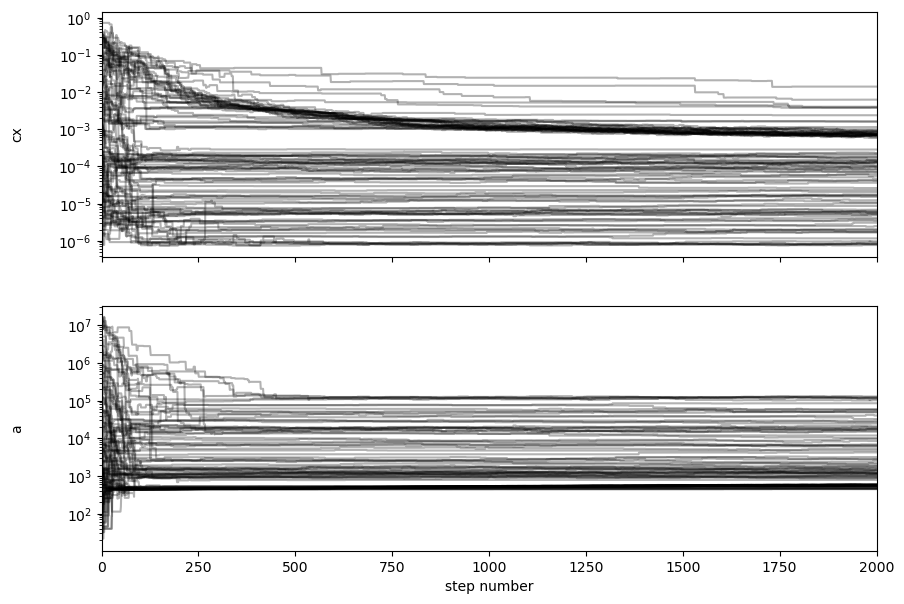

In [114]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["cx", "a", "lnf"]
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_yscale('log')

axes[-1].set_xlabel("step number");

In [120]:
samples.shape

(2000, 100, 2)

In [121]:
sampler.flatchain[0]

array([1.64884586e-04, 1.99035966e+06])

In [122]:
samples[:,1].shape

(2000, 2)

In [123]:
t = sampler.get_log_prob(flat=True, discard=300, thin=15)

In [124]:
t.shape

(11300,)

In [125]:
sampler.get_chain(flat=True, discard=1000, thin=15).shape

(6600, 2)

In [126]:
sampler.get_log_prob(flat=True, discard=300, thin=15)

array([-142.28194826, -140.79771005, -159.43539224, ..., -138.62090263,
       -142.46776819, -139.4963696 ])

(10000.0, 0.0)

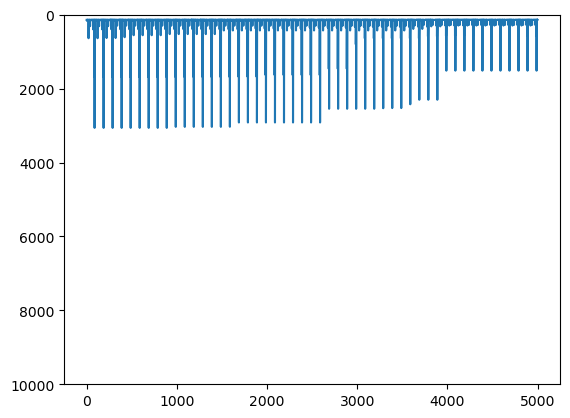

In [129]:
plt.plot(-sampler.get_log_prob(flat=True, discard=int(1000), thin=20))
plt.ylim(10000,0)
# plt.yscale('log')

In [128]:
sampler

In [75]:
flat_samples = sampler.get_chain(discard=int(samples.shape[0]*.3), thin=10, flat=True)
print(flat_samples.shape)

(14000, 2)


In [76]:
print(result.params['cx'].value, result.params['a'].value)

1768.2064476384646 7.387652069379413e-05


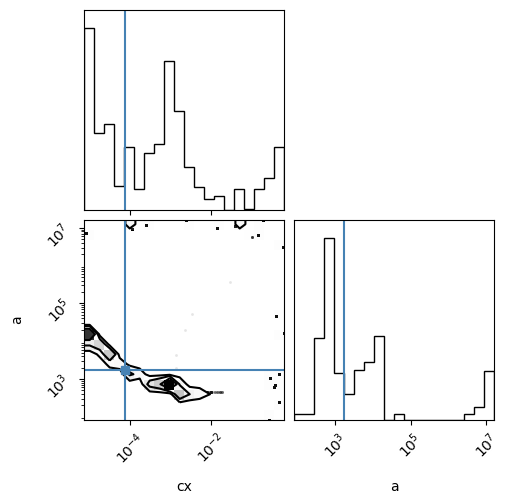

In [77]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[result.params['a'].value,result.params['cx'].value],
    axes_scale='log',
    # range=[(7e-5, 8e-5), (1e3, 2e3)]
    # range=[(7.3e-5, 7.5e-5),(1760, 1780)]
)


In [78]:
flat_samples.shape

(14000, 2)

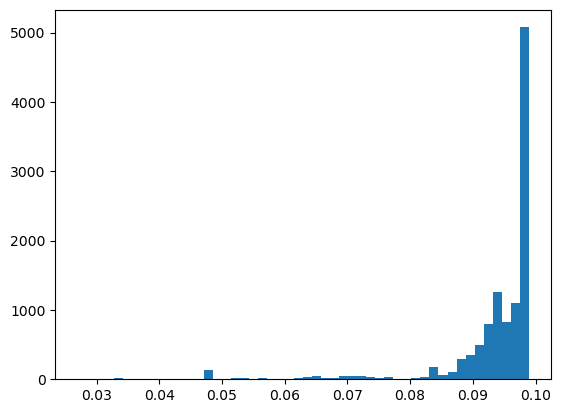

In [79]:
dcdt = models.hm_model_dcdt(t0=0, c0=430, a=flat_samples[:,0], cx=flat_samples[:,1],t=120)
quantiles = np.quantile(dcdt, [0.1, 0.5, 0.9])

dcdt[(dcdt<quantiles[0])] = np.nan
dcdt[(dcdt>quantiles[2])] = np.nan

plt.hist(dcdt, bins=50)
# plt.xlim(np.quantile(dcdt, [0.1, 0.9]))
plt.show()

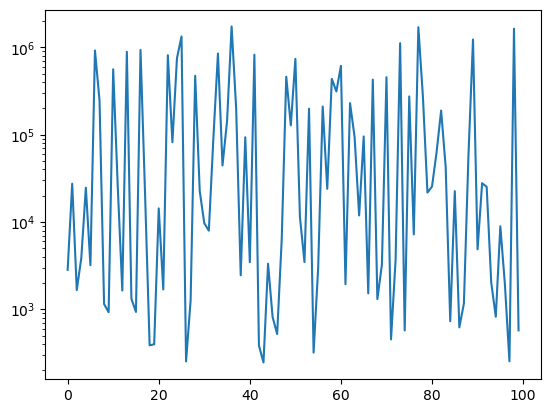

In [240]:
fig, ax =plt.subplots(1)
# ax.plot(np.logspace(np.log10(1800*10e-2), np.log10(1800*10e2), 100))
ax.plot(np.exp(np.random.uniform(low=np.log(1800*10e-2), high=np.log(1800*10e2), size=100)))

ax.set_yscale('log')

In [249]:
np.random.choice(100, 10)

array([ 2, 83, 12, 37, 80, 43, 61, 62, 41, 95])

In [128]:
np.log10(1800*10e-2), np.log10(1800*10e2)

(2.255272505103306, 6.2552725051033065)

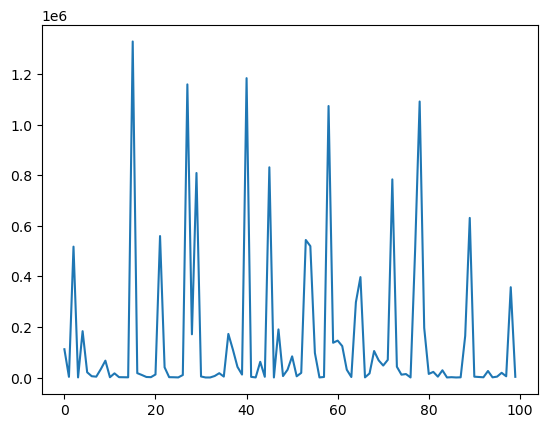